In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.show()

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 180
mpl.rcParams.update({'font.size': 10})

In [4]:
names_states = ['li_cCA', 'li_cCDCA', 'li_cSBA', 'li_uCA', 'li_uCDCA', 'li_uSBA',
                'bd_cCA', 'bd_cCDCA', 'bd_cSBA', 'bd_uCA', 'bd_uCDCA', 'bd_uSBA',
                'dsi_cCA', 'dsi_cCDCA', 'dsi_cSBA', 'dsi_uCA', 'dsi_uCDCA', 'dsi_uSBA',
                'co_cCA', 'co_cCDCA', 'co_cSBA', 'co_uCA', 'co_uCDCA', 'co_uSBA',
                'pl_cCA', 'pl_cCDCA', 'pl_cSBA', 'pl_uCA', 'pl_uCDCA', 'pl_uSBA',
                'fe_cCA', 'fe_cCDCA', 'fe_cSBA', 'fe_uCA', 'fe_uCDCA', 'fe_uSBA']

# Load Sips Simulation Results

In [5]:
import pickle

with open('data/sips_last_day.pkl', 'rb') as f:
    data_sips = pickle.load(f)

# Read Healthy States / Params

In [6]:
from src.rl_util import load_healthy_data
from src.sb3_BA_ode import BA_ode

In [7]:
max_ba_flow = 10000.
gut_deconj_freq_co_multiplier = 1.
gut_biotr_freq_CA_multiplier = 1.

init_state, init_param, PSC_data = load_healthy_data(max_ba_flow, gut_deconj_freq_co_multiplier, gut_biotr_freq_CA_multiplier)

# Insert Pathological Params

In [8]:
# max_ba_flow = 3.
# gut_deconj_freq_co_multiplier = 0.835
# gut_biotr_freq_CA_multiplier = 1.

# init_param[26] = max_ba_flow
# init_param[11] *= gut_deconj_freq_co_multiplier
# init_param[13] *= gut_biotr_freq_CA_multiplier

# Run Simulation

In [9]:
from scipy.integrate import solve_ivp

In [10]:
dt = 1
tmax = 1440 * 112 + 1
n = int(tmax / dt)
t = np.linspace(0, tmax, n)

In [11]:
linear_ode_solution = solve_ivp(BA_ode, (0, tmax), init_state, t_eval=t, args=(init_param,))
rk45_sol = linear_ode_solution.y.T

# Plot Dynamics

In [12]:
from src.rl_eval import plot_sol, plot_one_day

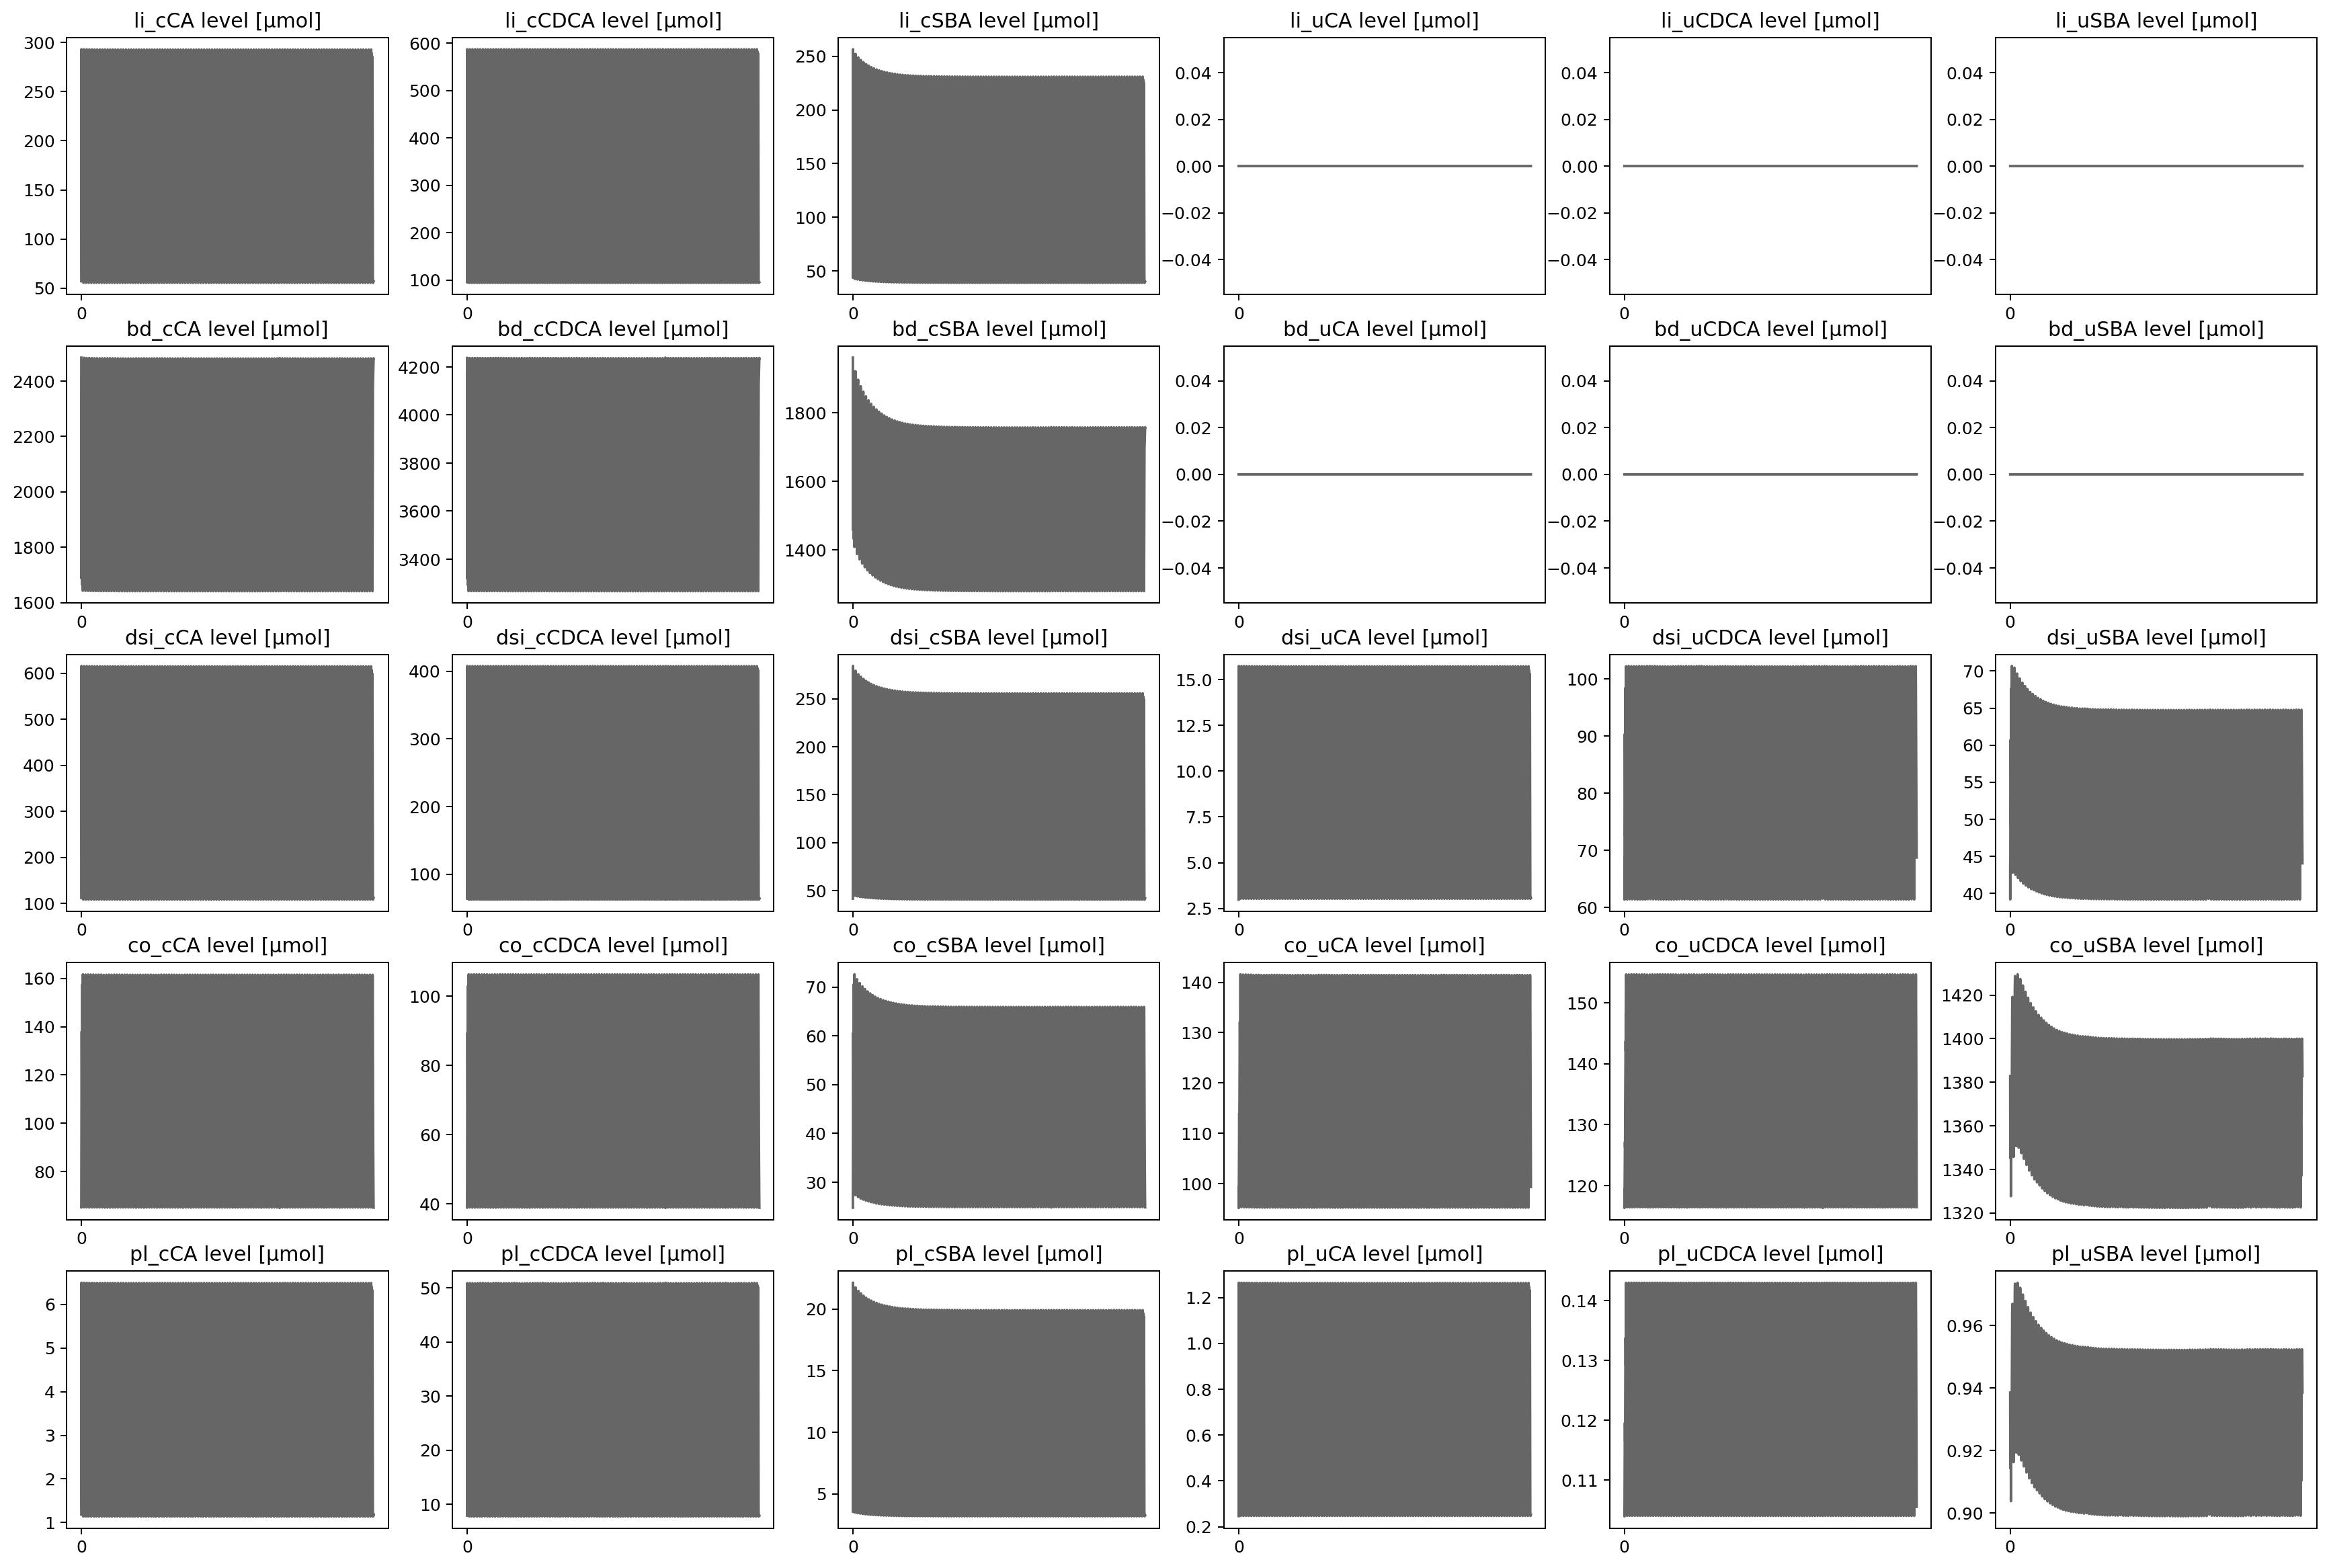

In [13]:
fig, axes = plt.subplots(5, 6, figsize=(24, 16))
axes = axes.flatten()

plot_sol(rk45_sol, t, axes, color='black', label='healthy')

# Plot One-Day Dynamics

In [14]:
# plot_one_day(rk45_sol[-1441:,:].T)

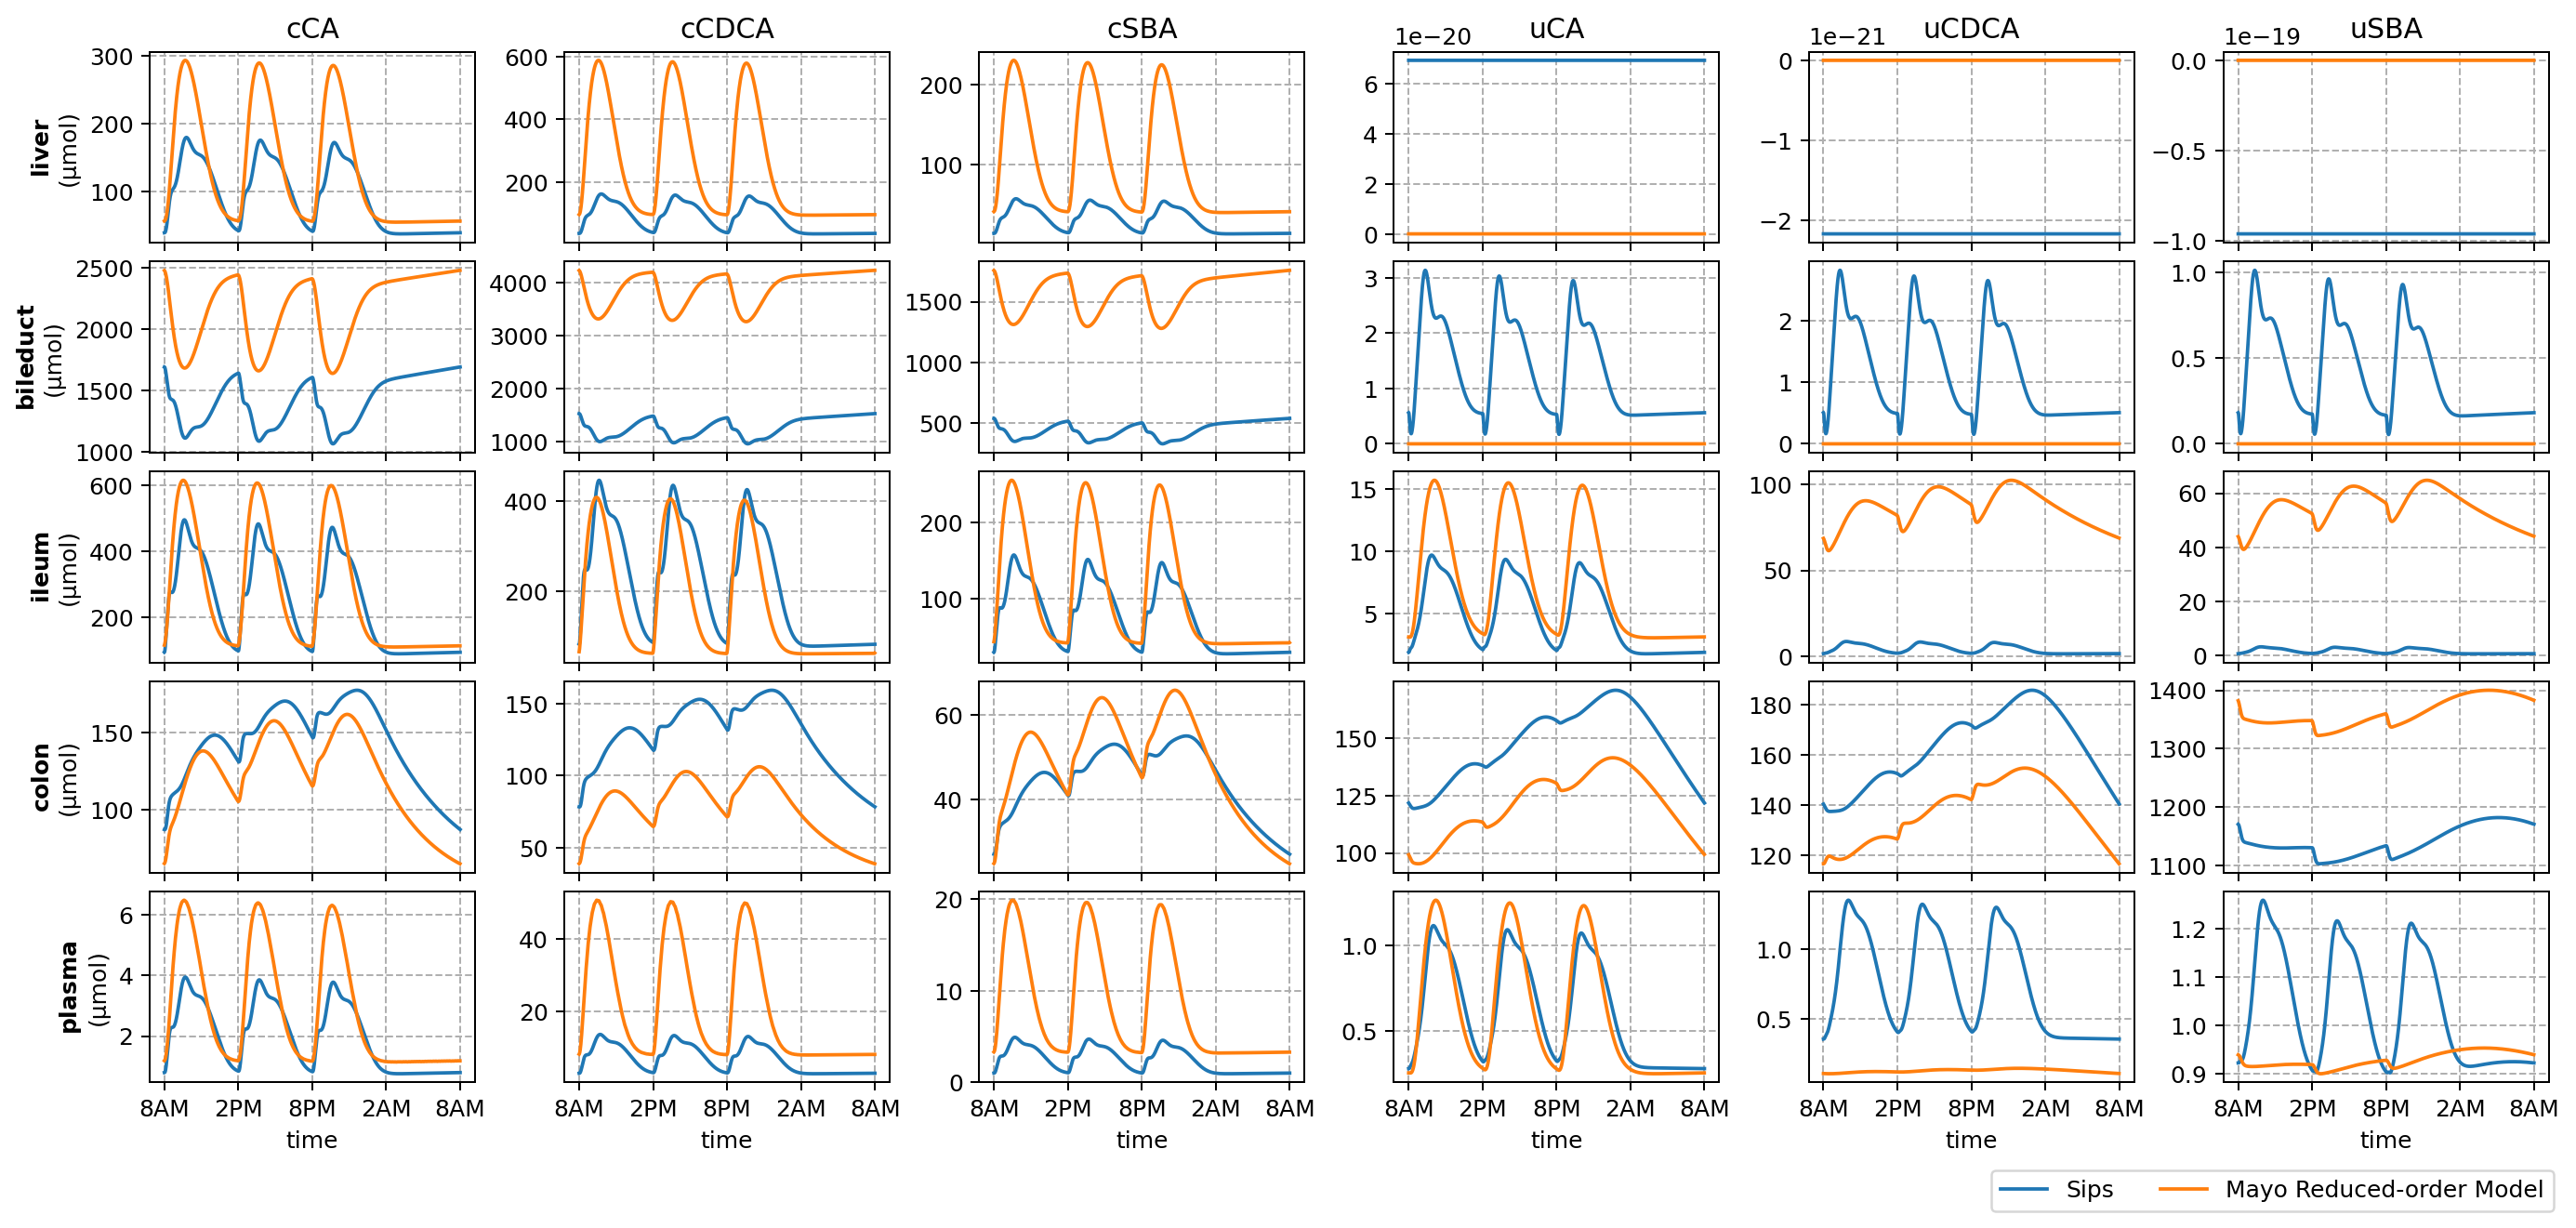

In [15]:
last_data_sips, last_data_reduced = [], []

fig, axes = plt.subplots(5, 6, figsize=(18.5, 8))
axes = axes.flatten()

state_idx = 0
for idx, name in enumerate(names_states[:30]):
    data_sips_t = (data_sips["timepoints"] - data_sips["timepoints"][0])/60
    data_sips_sol = data_sips["states"].loc[data_sips["group_names"][name]].sum()
    
    if 'pl_' in name:
        axes[idx].plot(data_sips_t, data_sips_sol * 3.15, label="Sips")
    else:
        axes[idx].plot(data_sips_t, data_sips_sol, label="Sips")


    data_reduced_t = (t[-1440:] - t[-1440:][0])/60
    if idx not in [3,4,5,9,10,11]:
        data_reduced_sol = rk45_sol[-1440:, state_idx]
        axes[idx].plot(data_reduced_t, data_reduced_sol, label="Mayo Reduced-order Model")        
        state_idx += 1
    else:
        axes[idx].plot(data_reduced_t, np.zeros(shape=rk45_sol[-1440:, 0].shape), label="Mayo Reduced-order Model")
    
    if idx < 6:
        axes[idx].set_title(name.split("_")[-1])
    
    axes[idx].set_xticks([0,6,12,18,24])
    axes[idx].set_xticklabels(["8AM", "2PM", "8PM", "2AM", "8AM"])
    if idx >= 24:
        axes[idx].set_xlabel('time')
    else:
        axes[idx].xaxis.set_ticklabels([])

    #################### FOR CALCULATING DELTA ####################
    if idx not in [3,4,5,9,10,11]:
        last_data_reduced.append(data_reduced_sol[-1])
        if 'pl_' in name:
            last_data_sips.append(data_sips_sol.values[-1] * 3.15)
        else:
            last_data_sips.append(data_sips_sol.values[-1])
    #################### FOR CALCULATING DELTA ####################
        
axes[0].set_ylabel(r"$\bf{liver}$"+"\n(\u03BCmol)")
axes[6].set_ylabel(r"$\bf{bile duct}$"+"\n(\u03BCmol)")
axes[12].set_ylabel(r"$\bf{ileum}$"+"\n(\u03BCmol)")
axes[18].set_ylabel(r"$\bf{colon}$"+"\n(\u03BCmol)")
axes[24].set_ylabel(r"$\bf{plasma}$"+"\n(\u03BCmol)")

axes[29].legend(ncol=6, bbox_to_anchor=(1.05, -0.4), loc='upper right')
for ax in axes:
    ax.grid(which='both', linestyle='--')
plt.subplots_adjust(hspace=0.1, wspace=0.275)

In [16]:
res = (np.log10(last_data_reduced) - np.log10(last_data_sips)) / np.log10(last_data_sips)

np.set_printoptions(suppress=True, precision=4)

print(res)
print(sum(res**2))

[  0.0972   0.2737   0.445    0.0514   0.1391   0.1874   0.0426  -0.0596
   0.1058   0.8301   7.2059  -8.4119  -0.0656  -0.1605  -0.0263  -0.0423
  -0.0376   0.0235  -1.7298   1.0624 -99.6912   0.0739   1.1627  -0.225 ]
10067.626110701483


In [17]:
np.array(last_data_reduced)

array([  56.9191,   95.6127,   40.1603, 2482.0478, 4237.1263, 1757.7277,
        112.3285,   64.1756,   42.1677,    3.1014,   68.7462,   44.0646,
         64.9897,   38.9435,   24.8898,   99.3499,  116.4701, 1382.8275,
          1.1825,    7.9694,    3.278 ,    0.2519,    0.1055,    0.9385])

**NORMAL_LIVER_BA**

In [18]:
rk45_sol[-1440:,:3].sum()

np.float64(684052.6004915552)

**NORMAL_DIGESTION**

In [19]:
rk45_sol[-1440:,6:12].sum()

np.float64(995329.7084522182)